# UN Analysis

Analysis of UN actors in agreement-actor networks.


In [35]:
__author__      = 'Roy Gardner'

%run ./network_functions.py


## Load the agreement-actor data

- Load data into a binary-valued relation matrix (BVRM) with agreements in rows and actors in columns
- Matrix values are zero except where a relation between an agreement and an actor exists where the value is one
- Apart from the matrix other data are extracted or computed
- All data are stored in data_dict


In [2]:

data_path = './data/'
nodes_file = 'node_table.csv'
links_file = 'links_table.csv'
agreements_dict = 'agreements_dict.json'

data_dict = load_agreement_actor_data(nodes_file,links_file,agreements_dict,data_path)
print(data_dict.keys())


dict_keys(['agreements_dict', 'dates_dict', 'nodes_data', 'nodes_header', 'links_data', 'links_header', 'agreement_vertices', 'actor_vertices', 'vertices_dict', 'color_map', 'matrix'])


In [59]:
print(len(data_dict['agreement_vertices']))
print(len(data_dict['actor_vertices']))



1642
1092


## Collect UN actor indices and IDs

In [57]:

un_actors_list = []

for actor_index,actor_id in enumerate(data_dict['actor_vertices']):
    if len(actor_id) == 0:
        continue
    if not actor_id.startswith('IGO_') and not actor_id.startswith('COA_'):
        continue
    actor_data = data_dict['vertices_dict'][actor_id]
    actor_name = actor_data[data_dict['nodes_header'].index('node_name')]
    if 'United Nations' in actor_name or actor_name.startswith('UN') or ' UN' in actor_name:
        un_actors_list.append((actor_index,actor_id,actor_name))

un_actors_list = sorted(un_actors_list,key=lambda t:t[2])

# Print ready for insertion in LaTex document
latex = False
if latex:
    for t in un_actors_list:
        s = t[2] + ' & ' + '\\_'.join(t[1].split('_')) + ' \\\\'
        print(s)
        print('\\hline')
    

## Get UN actor biadjacency matrices

There are two matrices:

1. UN-only matrix: 
    - Rows are agreements that have at least one UN signatory
    - Columns are UN actors
2. UN actors and non-UN co-signatories matrix:
    - Rows are agreements that have at least one UN signatory (as above)
    - Columns are all the actors who are signatories to the row agreements

The indices of the agreements and actors that constitute the above matrices are:

- agreement_indices: Indices into `data_dict['agreement_vertices']` and therefore rows of `data_dict['matrix']`
- un_indices: Indices into `data_dict['actor_vertices']` and therefore columns of `data_dict['matrix']` for UN actors only
- actor_indices: Indices into `data_dict['actor_vertices']` and therefore columns of `data_dict['matrix']` for UN actors and co-signatories


In [24]:
un_indices = [t[0] for t in un_actors_list]

matrix = data_dict['matrix']

# Reduce the matrix to UN actor columns only
reduced_matrix = matrix[np.ix_(range(0,matrix.shape[0]),un_indices)]
# Get indices of agreement row containing at least one non-zero value, i.e., agreements signed by at least
# one of the UN actors
indices = np.nonzero(reduced_matrix)
agreement_indices = list(set(indices[0]))

# This is the UN actors only matrix
un_matrix = matrix[np.ix_(agreement_indices,un_indices)]
print(un_matrix.shape)

# Reduce the complete matrix to the UN agreement rows and all actors
reduced_matrix = matrix[np.ix_(agreement_indices,range(0,matrix.shape[1]))]

# Get indices of all non-zero actor columns for the agreement rows, i.e., UN actors and co-signatories
indices = np.nonzero(reduced_matrix)
actor_indices = list(set(indices[1]))

# This is the UN actors and non-UN co-signatories matrix
un_cosign_matrix = matrix[np.ix_(agreement_indices,actor_indices)]
print(un_cosign_matrix.shape)
print()

print('There are',un_matrix.shape[0],'agreements signed by at least one of',un_matrix.shape[1],\
      'UN actors, and one or more of',un_cosign_matrix.shape[1] - un_matrix.shape[1],'non-UN actors')

(371, 26)
(371, 536)

There are 371 agreements signed by at least one of 26 UN actors, and one or more of 510 non-UN actors


### Analysis: UN-only

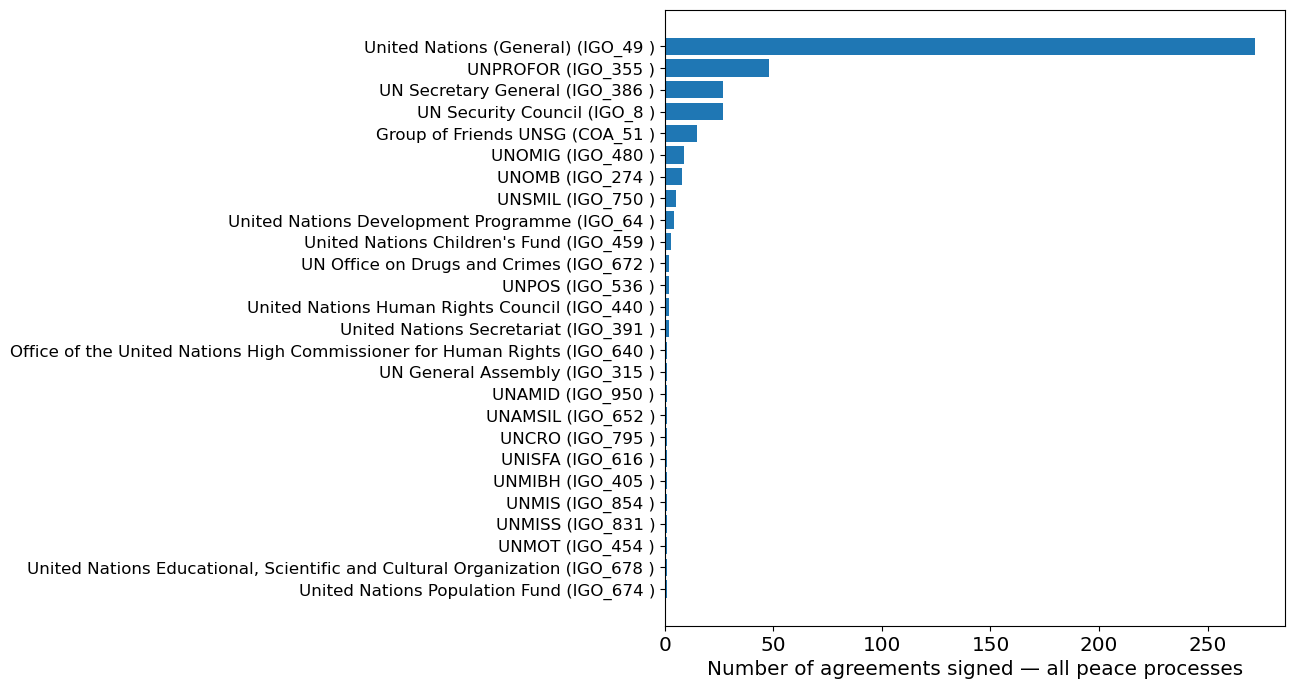

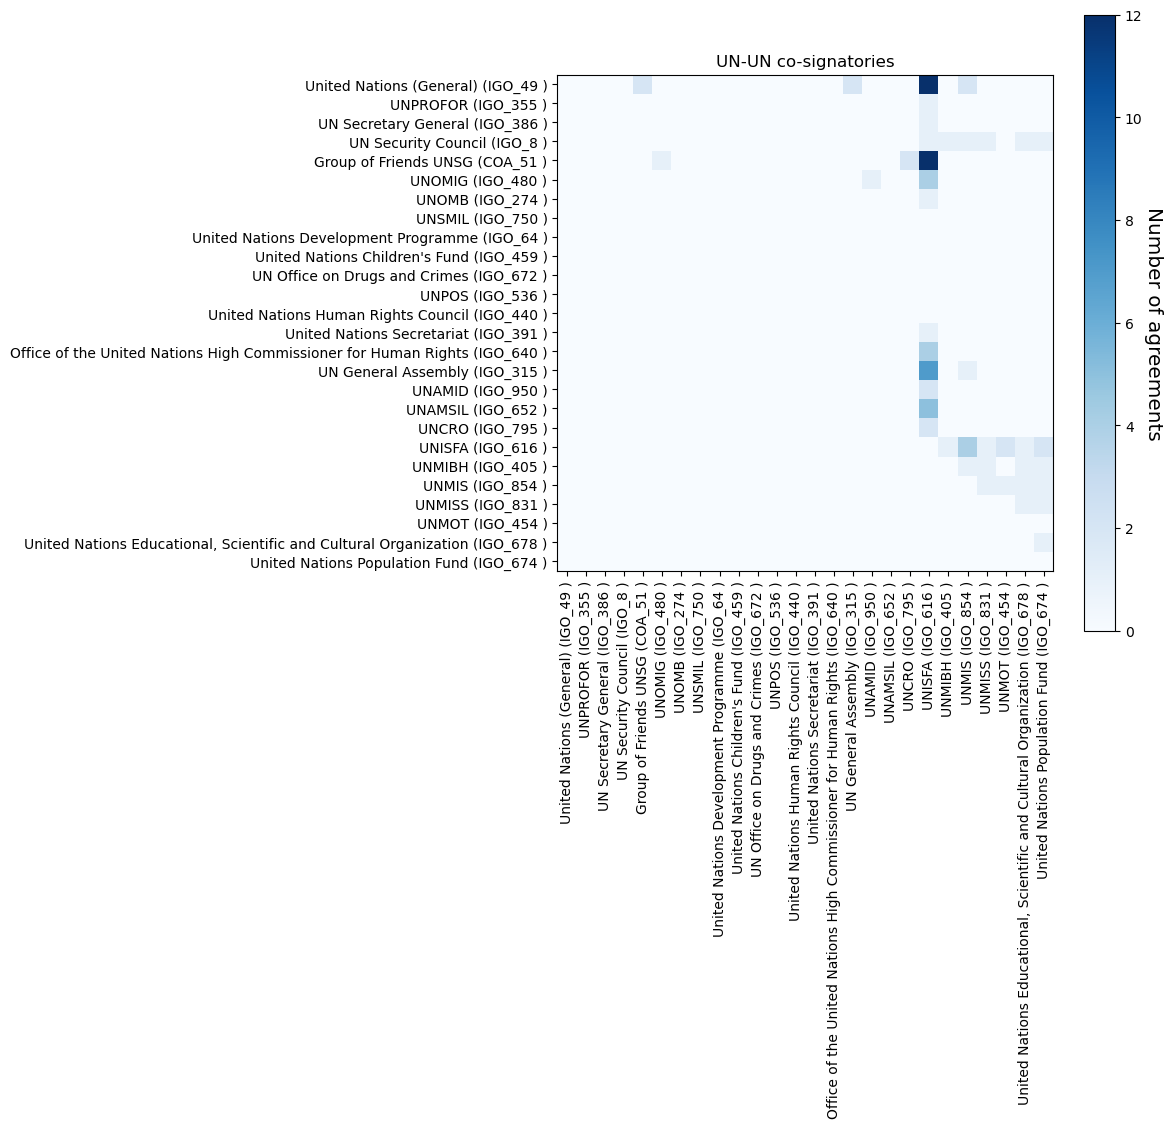

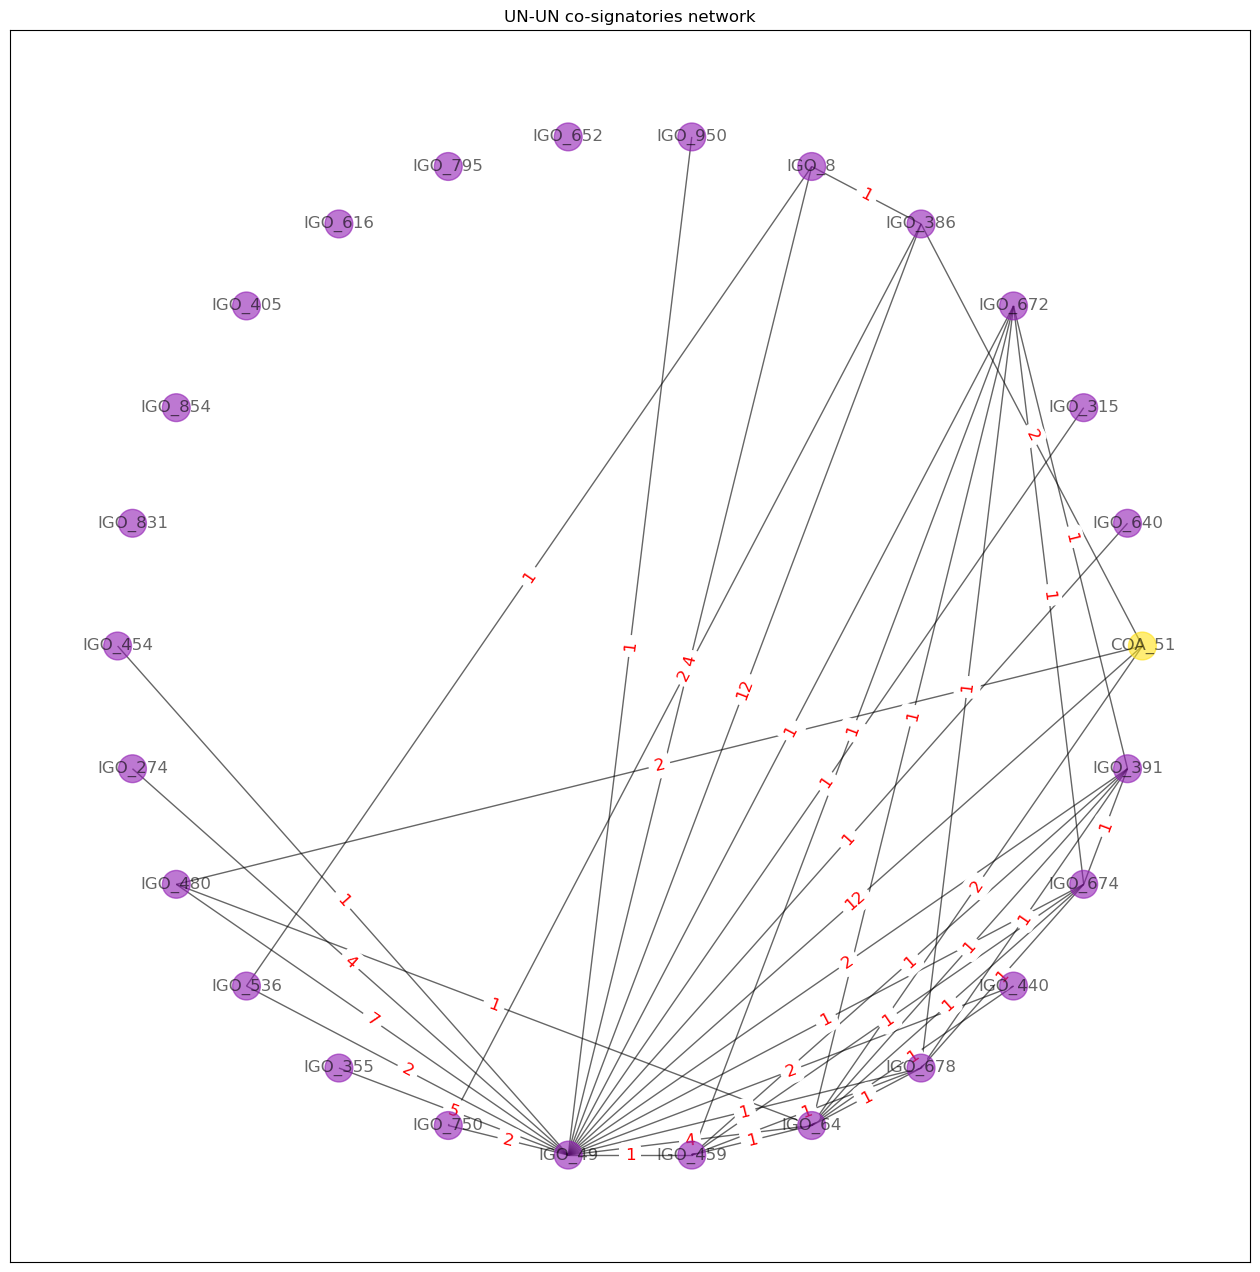

('Group of Friends UNSG', 'United Nations (General)', 12)
('UN Secretary General', 'United Nations (General)', 12)
('UNOMIG', 'United Nations (General)', 7)
('UNPROFOR', 'United Nations (General)', 5)
('UN Security Council', 'United Nations (General)', 4)
('UNOMB', 'United Nations (General)', 4)
('United Nations (General)', 'United Nations Development Programme', 4)
('Group of Friends UNSG', 'UN Secretary General', 2)
('Group of Friends UNSG', 'UNOMIG', 2)
('Group of Friends UNSG', 'United Nations Development Programme', 2)
('UN Secretary General', 'UNSMIL', 2)
('UNPOS', 'United Nations (General)', 2)
('UNSMIL', 'United Nations (General)', 2)
('United Nations (General)', 'United Nations Human Rights Council', 2)
('United Nations (General)', 'United Nations Secretariat', 2)
('Office of the United Nations High Commissioner for Human Rights', 'United Nations (General)', 1)
('UN General Assembly', 'United Nations (General)', 1)
('UN Office on Drugs and Crimes', 'United Nations (General)', 

In [69]:
# Get UN actor labels

co_matrices = get_cooccurrence_matrices(un_matrix)


# Co-occurrence diagonal is the columns marginal of the UN-only biadjacency matrix

diag = np.diag(co_matrices[0])
a = list(zip(diag,un_actors_list))
a = sorted(a,key=lambda t:t[0],reverse=True)
diag = [t[0] for t in a]
label_list = [t[1][2] + ' (' + t[1][1] + ' )' for t in a]

latex = False
if latex:
    for t in a:
        s = t[1][2] + ' & ' + str(t[0]) + ' \\\\'
        print(s)
        print('\\hline')

f = plt.figure(figsize=(8,8))
plt.barh(range(0,len(diag)),diag)
plt.yticks(range(0,len(label_list)),label_list,fontsize='large')
plt.xticks(fontsize='x-large')
plt.xlabel('Number of agreements signed — all peace processes',fontsize='x-large')
plt.gca().invert_yaxis()
plt.show()

# Upper triangle of actor co-occurence matrix
actor_upper = np.triu(co_matrices[0],k=1)

f = plt.figure(figsize=(8,8))
plt.imshow(actor_upper,cmap=plt.cm.Blues)
plt.xticks(range(0,len(label_list)),label_list,rotation=90)
plt.yticks(range(0,len(label_list)),label_list)
cbar = plt.colorbar()
cbar.set_label('Number of agreements',rotation=270,labelpad=15,fontsize='x-large')
plt.title('UN-UN co-signatories')
plt.show()

display_comatrix_as_networkx_graph(co_matrices[0],un_indices,data_dict['actor_vertices'],data_dict,\
                                   title='UN-UN co-signatories network')

rc = np.nonzero(actor_upper) # Row and column indices of non-zero pairs
z = list(zip(list(rc[0]),list(rc[1])))
scores = [(un_actors_list[t[0]][2],un_actors_list[t[1]][2],actor_upper[t[0]][t[1]]) for t in z]
scores = sorted(scores,key=lambda t:t[2],reverse=True)
for t in scores:
    print(t)


### Analysis: UN and non-UN co-signatories

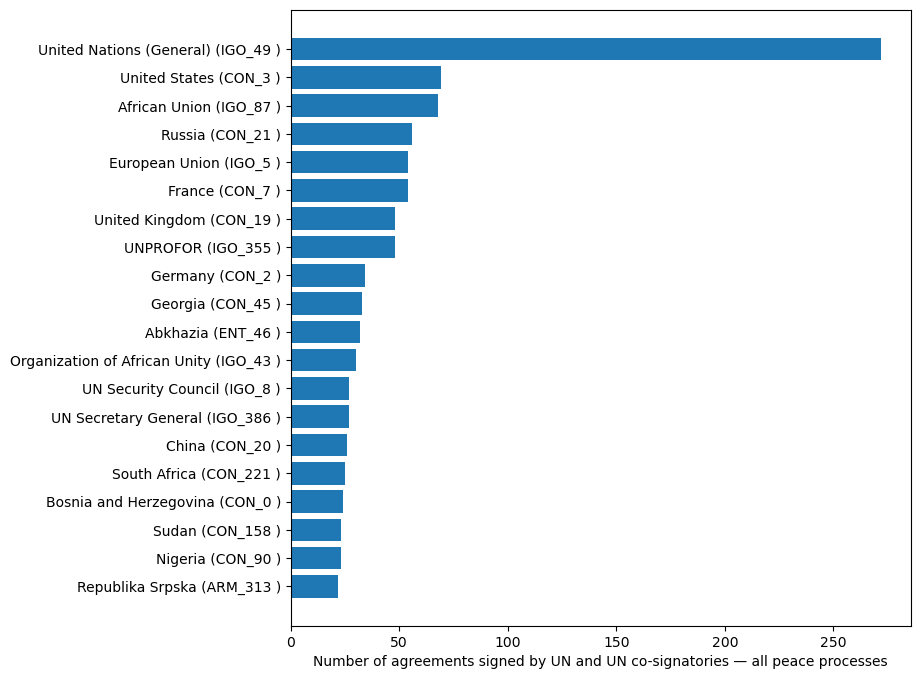

1287
('United Nations (General)', 'African Union', 65)
('United Nations (General)', 'United States', 62)
('European Union', 'United Nations (General)', 51)
('Russia', 'United Nations (General)', 47)
('France', 'United Nations (General)', 47)
('United Kingdom', 'United Nations (General)', 41)
('United Nations (General)', 'Organization of African Unity', 30)
('Georgia', 'United Nations (General)', 28)
('Germany', 'United Nations (General)', 28)
('United Nations (General)', 'Abkhazia', 27)
('South Africa', 'United Nations (General)', 24)
('Sudan', 'United Nations (General)', 22)
('Organization for Security and Cooperation in Europe', 'United Nations (General)', 21)
('United Nations (General)', 'Congo, Democratic Republic of the', 21)
('Economic Community of West African States', 'United Nations (General)', 20)
('China', 'United Nations (General)', 20)
('Nigeria', 'United Nations (General)', 20)
('United Nations (General)', 'Uganda', 20)
('Canada', 'United Nations (General)', 19)
('Norway'

In [48]:
co_matrices = get_cooccurrence_matrices(un_cosign_matrix)
actor_upper = np.triu(co_matrices[0],k=1)


un_cosign_actor_list = []
for actor_index in actor_indices:
    actor_id = data_dict['actor_vertices'][actor_index]
    actor_data = data_dict['vertices_dict'][actor_id]
    actor_name = actor_data[data_dict['nodes_header'].index('node_name')]
    un_cosign_actor_list.append((actor_index,actor_id,actor_name))

diag = np.diag(co_matrices[0])
a = list(zip(diag,un_cosign_actor_list))
a = sorted(a,key=lambda t:t[0],reverse=True)
diag = [t[0] for t in a]
label_list = [t[1][2] + ' (' + t[1][1] + ' )' for t in a[0:20]]

f = plt.figure(figsize=(8,8))
plt.barh(range(0,len(diag[0:20])),diag[0:20])
plt.yticks(range(0,len(label_list)),label_list)
plt.xlabel('Number of agreements signed by UN and UN co-signatories — all peace processes')
plt.gca().invert_yaxis()
plt.show()

rc = np.nonzero(actor_upper) # Row and column indices of non-zero pairs
z = list(zip(list(rc[0]),list(rc[1])))
scores = [(un_cosign_actor_list[t[0]][2],un_cosign_actor_list[t[1]][2],actor_upper[t[0]][t[1]]) for t in z if\
             un_cosign_actor_list[t[0]][0] in un_indices or un_cosign_actor_list[t[1]][0] in un_indices]
scores = sorted(scores,key=lambda t:t[2],reverse=True)
print(len(scores))
for t in scores[0:40]:
    print(t)
